In [5]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Libreria surprise para entrenamiento
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

In [6]:
# Cargar el conjunto de datos de scores
df = pd.read_csv("datasets/scores.csv")

# Cargar el conjunto de datos de movies para sacar luego el titulo de las peliculas
df_titles = pd.read_csv("datasets/movies_titles.csv")

In [7]:
# Del dataset de peliculas solo nos interesa quedarnos con el id y su titulo

df_titles = df_titles[['id','title']]

df_titles = df_titles.reset_index(drop=True)

df_titles

,id,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker
...,...,...
22993,ns8803,zodiac
22994,ns8804,zombie dumb
22995,ns8805,zombieland
22996,ns8806,zoom


In [8]:
# Pasos previos a realización de la predicción

N_filas = 100000 # Limitamos el dataset a N_filas

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['userId', 'movieId', 'score']][:N_filas], reader)

# Separamos nuestros datos

trainset, testset = train_test_split(data, test_size=.25)


In [9]:
# Entrenamos el modelo SVD

model = SVD()

model.fit(trainset)

In [10]:
# Predecimos

predictions = model.test(testset)

In [11]:
predictions[1]

Prediction(uid=619, iid='as1262', r_ui=3.0, est=3.7077202663580517, details={'was_impossible': False})

In [12]:
# Hacemos una predicción con userId y movieId al azar

model.predict(9, 'ns5709')

Prediction(uid=9, iid='ns5709', r_ui=None, est=4.128992826619148, details={'was_impossible': False})

### Predicción completa para un usuario aleatorio

In [13]:
# Tomaremos un usuario al azar para hacerle una recomendación

usuario = 44200
score = 4  # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df[(df.userId == usuario) & (df.score >= score)]

df_user = df_user.reset_index(drop=True)

df_titles.rename(columns={'id': 'movieId'}, inplace=True)

df_user = pd.merge(df_user, df_titles[['movieId', 'title']], left_on='movieId', right_on='movieId', how='left')

df_user

,userId,score,timestamp,movieId,title
0,44200,5.0,2013-11-10,as6154,paranormal
1,44200,5.0,2013-11-04,ns1757,lego jurassic world: legend of isla nublar
2,44200,5.0,2013-11-04,ds360,planes
3,44200,4.0,2015-11-07,as149,water (short)
4,44200,4.0,2014-10-18,as9420,the sacrament
...,...,...,...,...,...
192,44200,4.5,2016-03-09,ns3960,mercy black
193,44200,4.0,2016-03-09,as9069,the joyriders
194,44200,4.0,2016-03-09,ns2761,kannum kannum kollaiyadithaal
195,44200,4.5,2016-03-09,hs697,vanguard


In [14]:
recomendaciones_usuario = df_titles.iloc[:23000].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(22998, 2)


,movieId,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker


In [15]:
# Debemos extraer las películas que ya ha visto

usuario_vistas = df[df['userId'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(337, 4)


,userId,score,timestamp,movieId
4254853,44200,3.5,2013-11-12,as4033
4254854,44200,5.0,2013-11-10,as6154
4254855,44200,5.0,2013-11-04,ns1757
4254856,44200,5.0,2013-11-04,ds360
4254857,44200,3.0,2013-11-23,hs2132


In [16]:
# Eliminamos las peliculas que el usuario ya vió

recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario['movieId'].isin(usuario_vistas['movieId'])]

recomendaciones_usuario.shape

(22663, 2)

In [17]:
# Recomendamos

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)

In [18]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

      movieId                                      title  Estimate_Score
4816   as4817                           100 days to live        4.053376
18929  ns4739                         becoming champions        4.017393
9895    ds228  fantastic four: rise of the silver surfer        3.996760
14549   ns359                                    the net        3.978648
17725  ns3535                                    the spy        3.975234
20318  ns6128                                    alphago        3.973173
11296   hs179                               the simpsons        3.967120
20250  ns6060                a tale of love and darkness        3.953742
22547  ns8357        the imaginarium of doctor parnassus        3.947901
17750  ns3560            dave chappelle: sticks & stones        3.946549


### Predicción ingresando un id de usuario y uno de pelicula

In [41]:
def get_movie_recommendation(userId, movieId):
    # Obtenemos la predicción de la calificación que el usuario le daría a la película
    prediction = model.predict(userId, str(movieId))

    # Si la predicción es mayor o igual a 3.5, se recomienda la película
    if prediction.est >= 3.5:
        return "Recomendada", prediction.est
    else:
        return "No recomendada", prediction.est

In [43]:
# Ejemplo del funcionamiento de get_movie_recommendation

# ID del usuario
user_id = 12
# ID de la película
movie_id = 'as12'

# Obtener la recomendación para el usuario y la película
recommendation = get_movie_recommendation(user_id, movie_id)

# Imprimir la recomendación
print("La película es:", recommendation)

La película es: ('Recomendada', 3.8995635284285948)


## Evaluación del modelo

In [28]:
# Evaluamos el accuracy del modelo

from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9592


0.9591875309522079

### Optimización de los hiperparametros

In [29]:
from surprise.model_selection import cross_validate
import numpy as np

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9431  0.9529  0.9555  0.9505  0.0053  
Fit time          0.42    0.51    0.39    0.44    0.05    
Test time         0.18    0.29    0.17    0.21    0.05    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9518  0.9444  0.9523  0.9495  0.0036  
Fit time          0.39    0.41    0.41    0.40    0.01    
Test time         0.17    0.28    0.17    0.21    0.05    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9486  0.9517  0.9470  0.9491  0.0019  
Fit time          0.40    0.47    0.42    0.43    0.03    
Test time         0.28    0.18    0.17    0.21    0.05    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9492  0.9

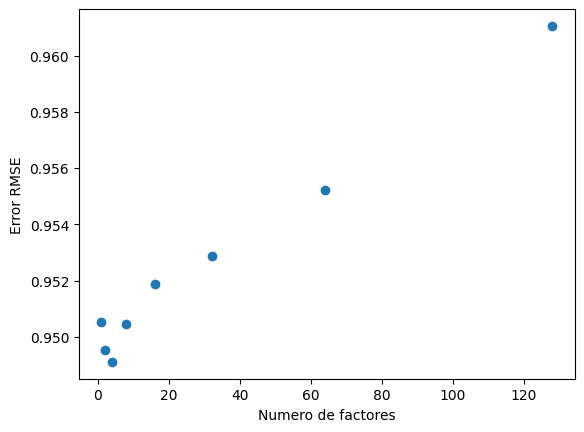

In [30]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

# Interfaz de usuario mediante gradio

In [90]:
# Esta función la creamos con el fin de saber el titulo de la pelicula que recomendamos o no

def get_movie_title(movieId):
    return df_titles[df_titles.movieId == movieId].title.iloc[0].title()

In [91]:
# Probamos la función
get_movie_title('as113')

'Whitechapel'

In [92]:
# Utilizaremos la funcion "get_movie_recommendation" previamente declarada 
# y la de get_movie_title recientemente declarada para crear una nueva función combinada

def combined_functions(userId, movieId):
    recommended, score = get_movie_recommendation(userId, movieId)
    title = get_movie_title(movieId)
    return (recommended, score, title)


In [93]:
combined_functions(1, 'as11')

('Recomendada', 4.014015939181389, 'Forest Fairies')

In [31]:
# Importo la libreria de gradio para hacer la interfaz
import gradio as gr

In [99]:
title = str("Sistema de recomendación de peliculas")

with gr.Blocks(title= title) as demo:
    text = gr.components.HTML("""
    <h1>Bienvenido al sistema de recomendación de peliculas!</h1>
    """)
    userId = gr.inputs.Number(label="Ingresa tu id")
    movie = gr.Textbox(label="Ingresa una id de pelicula")
    get_recommendation_btn = gr.Button("Averigua si la pelicula es recomendada para ti")
    title = gr.Textbox(label = "Nombre de la pelicula:")
    output = gr.Textbox(label="¿Se recomienda la pelicula?")
    score = gr.Textbox(label="Score predicho:")
    get_recommendation_btn.click(fn=combined_functions, inputs=[userId,movie], outputs=[output, score, title])

demo.launch(share=True)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7885
Running on public URL: https://efc51905-dc7f-4d5f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
